In [35]:
!pip install keras h5py
%matplotlib inline

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [36]:
import os, datetime, shutil
import numpy as np
import keras
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from keras import layers

from tensorboard import notebook
from IPython.core.display import Image, display

import matplotlib.pyplot as plt

print (f'TF version: {tf.__version__}')

TF version: 2.3.1


In [37]:
DATASET_ROOT = 'dataset'
CLASSES = ['cat', 'dog']
FULL_DATA_DIR = os.path.join(DATASET_ROOT, 'dataset')
TRAIN_DATA_DIR = os.path.join(DATASET_ROOT, 'train')
VAL_DATA_DIR = os.path.join(DATASET_ROOT, 'validation')
TEST_DATA_DIR = os.path.join(DATASET_ROOT, 'test')

## Construct datasets
1. Fetch list of all images in dataset
2. Split the list into the two classes: cats and dogs
3. Split each class into training, validation and testing subdatasets
4. Copy the original images/blobs into the new directories

In [38]:
def move_file(origin, dest):
    # Make sure directory exists while copying
    dest_dir = os.path.dirname(os.path.abspath(dest))
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)
    shutil.copyfile(origin, dest)

def construct_datasets(val_ratio, test_ratio):
    
    # Remove any existing directories
    for _dir in [TRAIN_DATA_DIR, VAL_DATA_DIR, TEST_DATA_DIR]:
        if os.path.exists(_dir):
            shutil.rmtree(_dir)
    
    files = os.listdir(FULL_DATA_DIR)
    np.random.shuffle(files)
    
    subsets = list()
    for _class in CLASSES:
        subsets.append(list(filter(lambda img_name: _class in img_name, files)))
    
    for _class, subset in zip(CLASSES, subsets):
        train, val, test = np.split(subset, [int(len(subset)* (1 - (val_ratio + test_ratio))), int(len(subset)* (1 - test_ratio))])
        
        for _subset, _dir in zip([train, val, test], [TRAIN_DATA_DIR, VAL_DATA_DIR, TEST_DATA_DIR]):
            # Copy files to their respective subset directories (train, validation and test)
            for f in _subset:
                from_path = os.path.join(FULL_DATA_DIR, f)
                to_path   = os.path.join(_dir, f'{_class}s', f)
                move_file(from_path, to_path)

# Split dataset into chunks whereof 80% is training, 15% is validation and 5% is test
construct_datasets(val_ratio=0.15, test_ratio=0.05)

Class "cat" has 1200 training, 225 validation and 75 samples


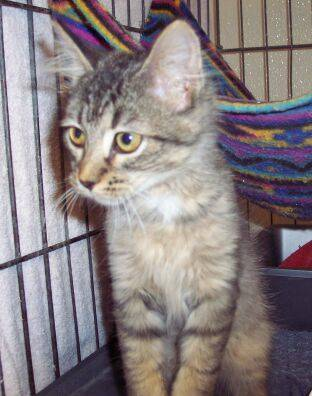

Class "dog" has 1200 training, 225 validation and 75 samples


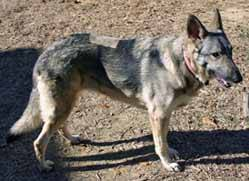

In [43]:
# Inspect data
for _class in CLASSES:
    train = os.listdir(os.path.join(TRAIN_DATA_DIR, f'{_class}s'))
    val   = os.listdir(os.path.join(VAL_DATA_DIR, f'{_class}s'))
    test  = os.listdir(os.path.join(TEST_DATA_DIR, f'{_class}s'))

    print(f'Class "{_class}" has {len(train)} training, {len(val)} validation and {len(test)} samples')
    display(Image(filename=os.path.join(TRAIN_DATA_DIR, f'{_class}s', train[0])))   

# Extend and augment datasets

In [44]:
patience = 20
imageSizeX = 256
imageSizeY = 256
batchSize = 32

In [45]:
def extended_datasets():
    # Training set
    train = ImageDataGenerator(
        rescale=1/255. ,
        rotation_range=40,
        width_shift_range=0.3,
        height_shift_range=0.3,
        shear_range=0.3,
        zoom_range=0.3,
        horizontal_flip=True,
        vertical_flip=True,
    ).flow_from_directory(
        directory=TRAIN_DATA_DIR,
        batch_size=batchSize,
        target_size=(imageSizeX, imageSizeY), 
        class_mode='binary'
    )
    
    # Validation set
    validation = ImageDataGenerator(
        rescale=1./255
    ).flow_from_directory(
        directory=VAL_DATA_DIR,
        batch_size=batchSize,
        target_size=(imageSizeX, imageSizeY), 
        class_mode='binary'
    )
    
    # Testing set
    test = ImageDataGenerator(
        rescale=1./255
    ).flow_from_directory(
        directory=TEST_DATA_DIR,
        batch_size=batchSize,
        target_size=(imageSizeX, imageSizeY), 
        class_mode='binary'
    )
    
    return train, validation, test

train_data, val_data, test_data = extended_datasets()


Found 2400 images belonging to 2 classes.
Found 450 images belonging to 2 classes.
Found 150 images belonging to 2 classes.


# Create model

In [54]:
def create_model():
    model = keras.Sequential([

        layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(imageSizeX, imageSizeY, 3)),
        layers.Conv2D(32, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Dropout(0.2),

        layers.Conv2D(64, 3, padding='same', activation='relu'),
        layers.Conv2D(64, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Dropout(0.2),

        layers.Conv2D(128, 3, padding='same', activation='relu'),
        layers.Conv2D(128, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Dropout(0.2),
        
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        
        layers.Dense(1, activation ='sigmoid')
    ])
    
    model.compile(
        optimizer='rmsprop',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
        
    return model

# Train model

In [55]:
def train_model(train_data, val_data):

    model = create_model()

    logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

    model.fit(
        train_data,
        epochs=10,
        validation_data=val_data,
        callbacks=[tensorboard_callback]
    )
    model.save('cats_dogs_model1.h5')
    return model


In [56]:
model = train_model(train_data, val_data)

Epoch 1/10
 6/75 [=>............................] - ETA: 26s - loss: 43.3989 - accuracy: 0.4896

KeyboardInterrupt: 

# Evaluation

In [20]:
test_loss, test_acc = model.evaluate(test_data, verbose=2)

5/5 - 0s - loss: 0.6640 - accuracy: 0.5200
